# Reference genome test (Ensemble 109 vs Siletti custom reference)

# Reference genome testing - Preprocessing

<div class="alert alert-warning">

**What these notebooks do**
    
The following collection of notebooks compares data of the data of the snrna human atlas of Siletti et.al (10X176-1, 10X176-2) to data of the snrna human atlas of van Regteren Altena et. al. (UMC-AR-g004-SCI7T024_S1_L004, UMC-AR-g004-SCI7T024_S2_L004). Both are aligned to two different reference genome: Ensemble 109 and the custom reference genome of Siletti which is based on Ensemble 109. All data objects were aligned with starsolo v2.7.10b (Siletti used 2.7.10a, but the differences do not influence the results) while using -soloFeatures Gene Velocyto. This test aims to identify the disparity created by the different reference genomes and if they can be used interchangably. 

The collection of notebooks contains four main sections: 1) Preprocessing, 2) Filtering, 3) Normalization, 4) Merging
    
<br>   
    
v**What the first section (Preprocessing) does**
    
This section takes the aligned h5 files and shapes the data with annotations and quality control metrics. This additional information will be used to filter the data and prepare it for subsequent processing. For each h5 file a <sample_name>_preprocessed.h5ad file will be made which contain all necessary annotation for subsequent filtering. The section contains the following important subsections:

* Doublet detection <br>
* Adding quality metrics and mitochondrial gene removal<br>
  
    
<br>   
    
**What the second section (Filtering) does**

This section visualizes various quality control metric values and filters the data based on a threshold made on the observations/domain knowledge. The section contains the following important subsections:

* Doublet filtering <br>
* UMIs and gene counts filtering <br>
    
<br> 
    
**What the third section (Normalization) does**
    
This section normalizes the data based on sequencing depth and gene length so the cells are comparable. Subsequently dimensional reduction and clustering are performed to visualize samples separately. The section contains the following important subsections:

* Normalization <br>
* Dimensional reduction <br>
* Marker genes and property annotation visualizations <br>
    
<br>
    
**What the fourth section (Merging) does**
    
This section merges the different datasets and visualizes the merged data. The section contains the following important subsections:

* Merging <br>
* Alignment parameter visualization <br>
</div>  



### Loading libraries
Using sc2_seurat environment, importing packages and setting parameters.

In [1]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/hpc/hers_basak/bin/miniconda3/envs/sc2_seurat/bin/python
3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:40:17) 
[GCC 9.4.0]
sys.version_info(major=3, minor=9, micro=9, releaselevel='final', serial=0)


In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))#embed HTML within IPython notebook and make containers 90% of screen
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import os
import matplotlib.pyplot as plt

%matplotlib inline
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white') #figure resolution and background color

# This is used
# os.path.join('data/'+object_names[i][6:10]+'_preprocessed.h5ad')
#sc.logging.print_versions()

### h5 files

In [3]:
#Siletti
siletti_custom='/home/hers_basak/jjiang/jack/outputs/count_files/homo_sap/siletti_2022/starsolo/custom_109/Solo.out/Velocyto/raw/'
siletti_standard='/home/hers_basak/jjiang/jack/outputs/count_files/homo_sap/siletti_2022/starsolo/standard_109/Solo.out/Velocyto/raw/'

#Anna van Regteren Altena
altena_custom='/home/hers_basak/jjiang/jack/outputs/count_files/homo_sap/van_regteren_altena_2023/starsolo/custom_109/UMC-AR-g004-SCI7T024_S1_L004/Solo.out/Velocyto/raw/'
altena_standard='/home/hers_basak/jjiang/jack/outputs/count_files/homo_sap/van_regteren_altena_2023/starsolo/standard_109/Solo.out/Velocyto/raw/'



In [4]:
#set data path
os.chdir('/home/hers_basak/jjiang/jack/outputs/deliverables/0_reference_genome_testing_custom_siletti')

In [5]:
os.getcwd()

'/hpc/hers_basak/rnaseq_data/Basaklab/jjiang/outputs/deliverables/0_reference_genome_testing_custom_siletti'

## Load data
The Gene Velocyto mode of Starsolo generates three mtx files: spliced.mtx, unspliced.mtx and ambiguous.mtx. These can be summed together to get the full count. The function "load Velocyto" does this for multiple folders and loads it into an anndata object. This function can take some time.. 
!cant use as function because variables will become local then

In [6]:
'''
Description:
    Loads the sum of Starsolo Velocyto output unspliced.mtx, spliced.mtx and 
    ambiguous.mtx as well as the barcode and features into an anndata object. 
    Note that it also filters out rows with less than 500 counts.

Parameters:
    paths: list of .../samplename/Solo.out/Velocyto/raw/ paths to mtx files
    samples: list of names for adata objects e.g. [SampleName] -> adata_SampleName

Output:
    AnnData objects with the sum count matrix in .X, barcodes as .obs_names and 
    features as .var_names.
    
''' 
def load_velocyto(paths: list[str], samples: list[str]):
    files = ['unspliced.mtx','spliced.mtx', 'ambiguous.mtx']
    for j in range(len(samples)):
        for i in range(len(files)):
            locals()["adata"+"_"+files[i]]=sc.read_mtx(f'{paths[j]}/{files[i]}')
            
        data = [locals()['adata_unspliced.mtx'], locals()['adata_spliced.mtx'], locals()['adata_ambiguous.mtx']]
        adata_siletti_standard = sum([adata.X for adata in data])
        
        locals()["adata"+"_"+samples[j]] = sc.AnnData(X=adata_siletti_standard.transpose())
        
        locals()["adata"+"_"+samples[j]].obs_names = pd.read_csv(f'{paths[j]}/barcodes.tsv', sep='\t',header=None).iloc[:,0]
        locals()["adata"+"_"+samples[j]].var_names = pd.read_csv(f'{paths[j]}/features.tsv', sep='\t',header=None).iloc[:,1]
        locals()["adata"+"_"+samples[j]].var['gene_ids'] = pd.read_csv(f'{paths[j]}/features.tsv', sep='\t',header=None).iloc[:,0]
        locals()["adata"+"_"+samples[j]].var['feature_types'] = pd.read_csv(f'{paths[j]}/features.tsv', sep='\t',header=None).iloc[:,2]
        locals()["adata"+"_"+samples[j]].var_names_make_unique()
        sc.pp.filter_cells( locals()["adata"+"_"+samples[j]], min_counts=500, inplace=True)
        print("adata"+"_"+samples[j],"is loaded")
        object_names.append("adata"+"_"+samples[j])

In [18]:
files = [siletti_custom, siletti_standard, altena_custom, altena_standard]
samples= ['siletti_custom', 'siletti_standard', 'altena_custom', 'altena_standard']
object_names =[]

paths=files

files = ['unspliced.mtx','spliced.mtx', 'ambiguous.mtx']
for j in range(len(samples)):
    for i in range(len(files)):
        locals()["adata"+"_"+files[i]]=sc.read_mtx(f'{paths[j]}/{files[i]}')

    data = [locals()['adata_unspliced.mtx'], locals()['adata_spliced.mtx'], locals()['adata_ambiguous.mtx']]
    adata = sum([adata.X for adata in data])

    locals()["adata"+"_"+samples[j]] = sc.AnnData(X=adata.transpose())

    locals()["adata"+"_"+samples[j]].obs_names = pd.read_csv(f'{paths[j]}/barcodes.tsv', sep='\t',header=None).iloc[:,0][1]
    locals()["adata"+"_"+samples[j]].var_names = pd.read_csv(f'{paths[j]}/features.tsv', sep='\t',header=None).iloc[:,1][1]
    
    locals()["adata"+"_"+samples[j]].var_names_make_unique()
    sc.pp.filter_cells( locals()["adata"+"_"+samples[j]], min_counts=500, inplace=True)
    print("adata"+"_"+samples[j],"is loaded")
    object_names.append("adata"+"_"+samples[j])

/hpc/hers_basak/bin/miniconda3/envs/sc2_seurat/lib/python3.9/site-packages/anndata/utils.py:220: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


adata_siletti_custom is loaded


/hpc/hers_basak/bin/miniconda3/envs/sc2_seurat/lib/python3.9/site-packages/anndata/utils.py:220: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


adata_siletti_standard is loaded


/hpc/hers_basak/bin/miniconda3/envs/sc2_seurat/lib/python3.9/site-packages/anndata/utils.py:220: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


adata_altena_custom is loaded


/hpc/hers_basak/bin/miniconda3/envs/sc2_seurat/lib/python3.9/site-packages/anndata/utils.py:220: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


adata_altena_standard is loaded


In [40]:
pd.read_csv(f'/home/hers_basak/jjiang/jack/outputs/count_files/homo_sap/van_regteren_altena_2023/starsolo/custom_109/UMC-AR-g004-SCI7T024_S1_L004/Solo.out/Velocyto/raw/features.tsv', sep='\t',header=None).iloc[:,1]

0           DDX11L1
1            WASH7P
2         MIR6859-1
3         MIR1302-2
4            OR4G4P
            ...    
59454     5_8S_rRNA
59455    AC007325.3
59456    AC007325.1
59457            U6
59458            U1
Name: 1, Length: 59459, dtype: object

In [43]:
adata_siletti_custom.var

gene_ids feature_types     mt   ribo  n_cells_by_counts  \
DDX11L1          NaN           NaN  False  False                  0   
WASH7P           NaN           NaN  False  False                130   
MIR6859-1        NaN           NaN  False  False                  0   
MIR1302-2        NaN           NaN  False  False                  0   
OR4G4P           NaN           NaN  False  False                  0   
...              ...           ...    ...    ...                ...   
5_8S_rRNA-8      NaN           NaN  False  False                  0   
AC007325.3       NaN           NaN  False  False                  0   
AC007325.1       NaN           NaN  False  False                  0   
U6-29            NaN           NaN  False  False                  0   
U1-5             NaN           NaN  False  False                  0   

             mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
DDX11L1         0.000000           0.000000             100.000000   
WASH7P          0.016166           0.016037              98.419837   
MIR6859-1       0.000000           0.000000             100.000000   
MIR1302-2       0.000000           0.000000             100.000000   
OR4G4P          0.000000           0.000000             100.000000   
...                  ...                ...                    ...   
5_8S_rRNA-8     0.000000           0.000000             100.000000   
AC007325.3      0.000000           0.000000             100.000000   
AC007325.1      0.000000           0.000000             100.000000   
U6-29           0.000000           0.000000             100.000000   
U1-5            0.000000           0.000000             100.000000   

             total_counts  log1p_total_counts  
DDX11L1               0.0             0.00000  
WASH7P              133.0             4.89784  
MIR6859-1             0.0             0.00000  
MIR1302-2             0.0             0.00000  
OR4G4P                0.0             0.00000  
...                   ...                 ...  
5_8S_rRNA-8           0.0             0.00000  
AC007325.3            0.0             0.00000  
AC007325.1            0.0             0.00000  
U6-29                 0.0             0.00000  
U1-5                  0.0             0.00000  

[59422 rows x 10 columns]

## Basic Preprocessing
### Doublet detection using scrublet
Doublets are droplets that captures two cells, which will lead to inconsistencies. So we need to detect and remove them. First we will annotate the objects with metadata.

https://github.com/swolock/scrublet
https://www.sciencedirect.com/science/article/pii/S2405471218304745

Following the advice of Chromium (below), for 8000 cells recovered 6.10%.
> https://uofuhealth.utah.edu/huntsman/shared-resources/gba/htg/single-cell/genomics-10x.php


In [22]:
names=samples

In [19]:
numberobj=len(object_names)

(8227, 59422)
(8213, 60619)
(6778, 59422)
(6775, 60619)


/hpc/hers_basak/bin/miniconda3/envs/sc2_seurat/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Detected doublet rate = 3.5%
Estimated detectable doublet fraction = 41.8%
Overall doublet rate:
	Expected   = 6.1%
	Estimated  = 8.4%


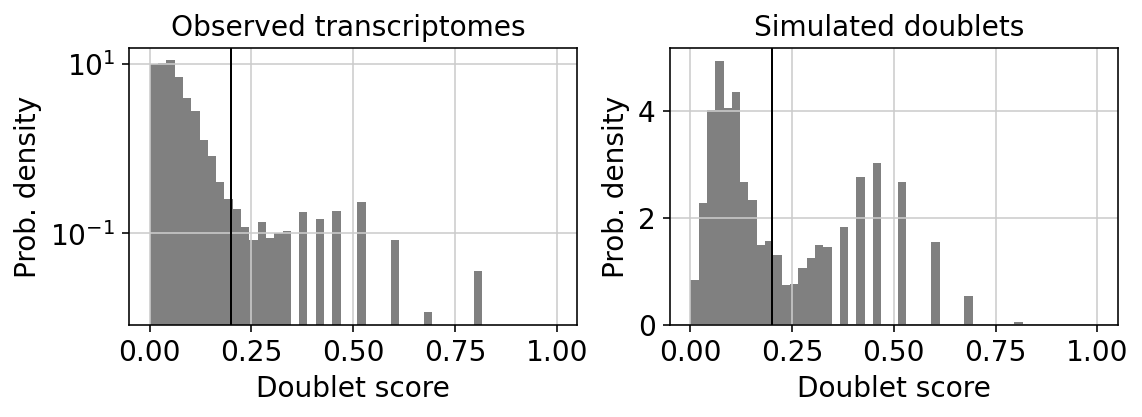

/hpc/hers_basak/bin/miniconda3/envs/sc2_seurat/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Detected doublet rate = 3.5%
Estimated detectable doublet fraction = 42.7%
Overall doublet rate:
	Expected   = 6.1%
	Estimated  = 8.3%


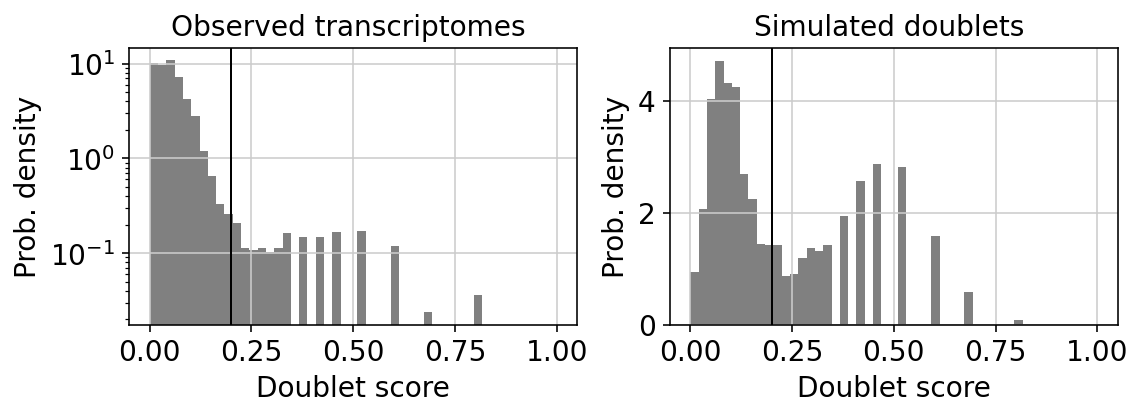

/hpc/hers_basak/bin/miniconda3/envs/sc2_seurat/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Detected doublet rate = 3.5%
Estimated detectable doublet fraction = 46.7%
Overall doublet rate:
	Expected   = 3.9%
	Estimated  = 7.6%


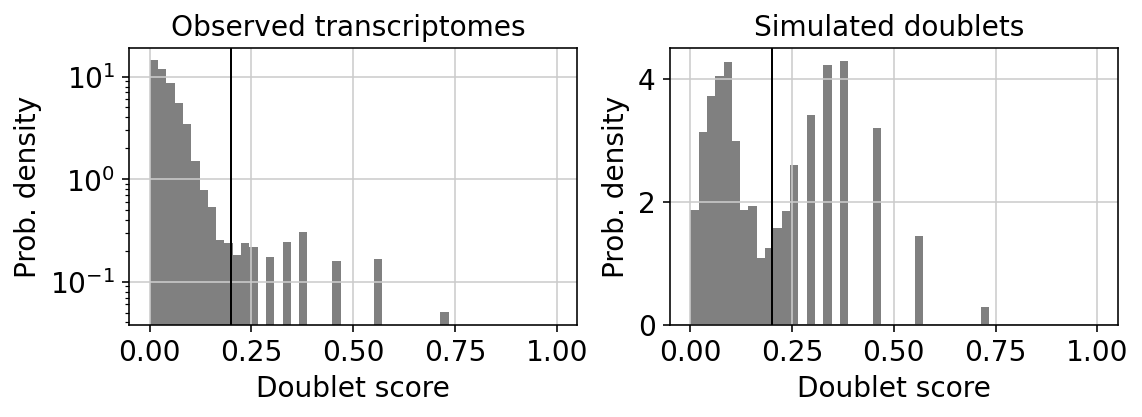

/hpc/hers_basak/bin/miniconda3/envs/sc2_seurat/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Detected doublet rate = 3.6%
Estimated detectable doublet fraction = 46.5%
Overall doublet rate:
	Expected   = 3.9%
	Estimated  = 7.8%


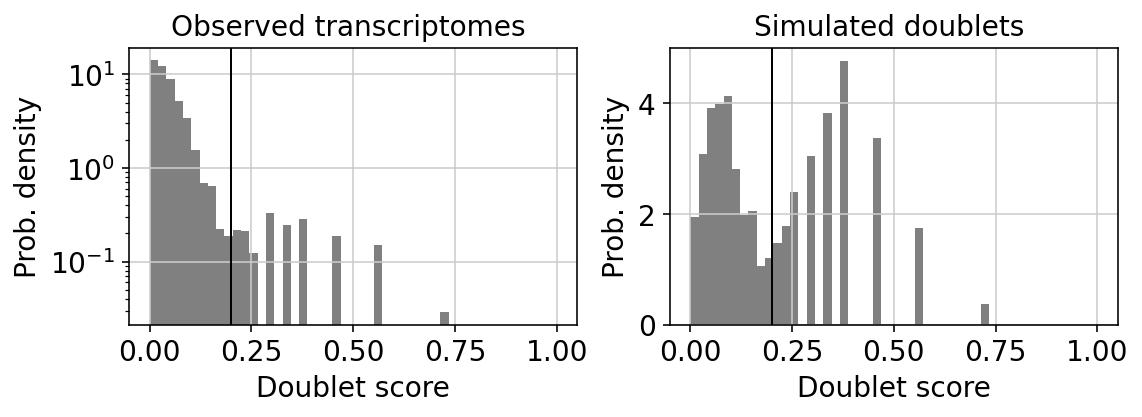

In [42]:
#manually adding metadata due to lack of metadata file
for i in range(numberobj):
    locals()[object_names[i]].obs['species'] = ['Homo sapien','Homo sapien','Homo sapien','Homo sapien'][i]
    locals()[object_names[i]].obs['sample_group'] = ['10X194-6_S31','10X194-6_S31','g004_S1','g004_S1'][i]
    locals()[object_names[i]].obs['atlas'] = ['siletti','siletti','altena','altena'][i]
    locals()[object_names[i]].obs['reference'] = ['custom','standard','custom','standard'][i]
    
#viewing object annotations
for i in range(numberobj):
    print(locals()[object_names[i]].shape)

thr = 0.20
expected_doublet_rates = [0.061,0.061,0.039,0.039] 
for i in range(numberobj):
    #predicts doublets and adds a score to objects
    sc.external.pp.scrublet(locals()[object_names[i]], expected_doublet_rate=expected_doublet_rates[i], stdev_doublet_rate=0.02, 
                            synthetic_doublet_umi_subsampling=1.0, knn_dist_metric='euclidean', normalize_variance=True, 
                            log_transform=False, mean_center=True, n_prin_comps=30, use_approx_neighbors=True, 
                            get_doublet_neighbor_parents=False, n_neighbors=None, threshold=thr, verbose=True, copy=False, random_state=0)
    #plot histogram of doublet scores(doesnt work in loop)
    sc.external.pl.scrublet_score_distribution(locals()[object_names[i]], scale_hist_obs='log', scale_hist_sim='linear', figsize=(8, 3),
                                               show=True,return_fig=True)


Check how many cells are higher than the threshold

In [23]:
for i in range(numberobj):
    print(names[i],'\n',locals()[object_names[i]].obs['predicted_doublet'].value_counts(),'\n')

siletti_custom 
 False    7984
True      243
Name: predicted_doublet, dtype: int64 

siletti_standard 
 False    7947
True      266
Name: predicted_doublet, dtype: int64 

altena_custom 
 False    6525
True      253
Name: predicted_doublet, dtype: int64 

altena_standard 
 False    6524
True      251
Name: predicted_doublet, dtype: int64 



### Scrublet simulation plot

siletti_custom


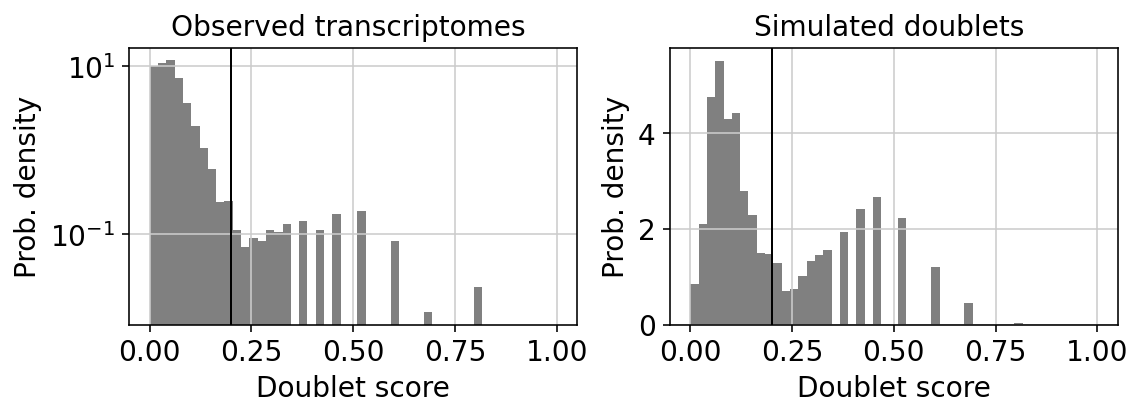

siletti_standard


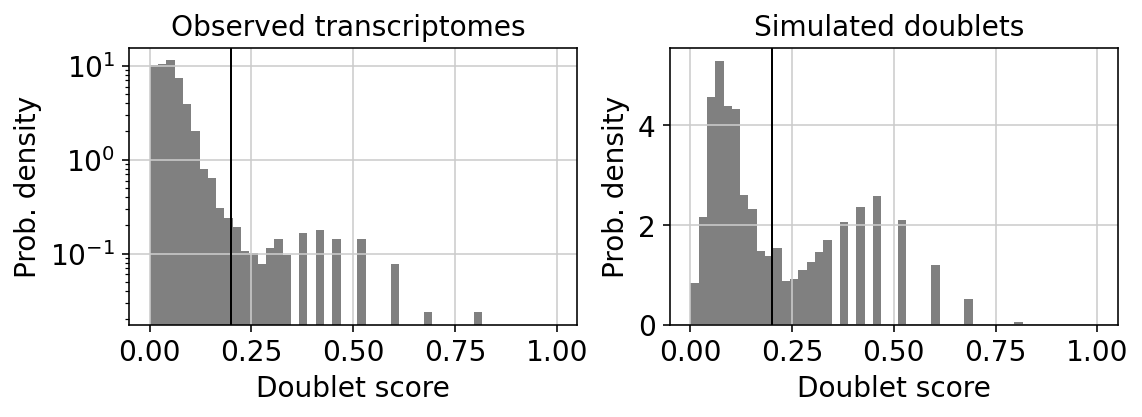

altena_custom


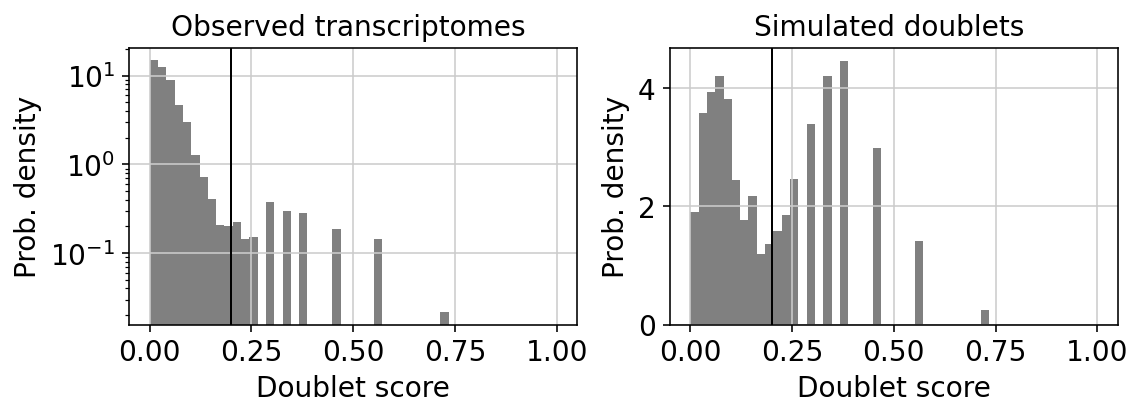

altena_standard


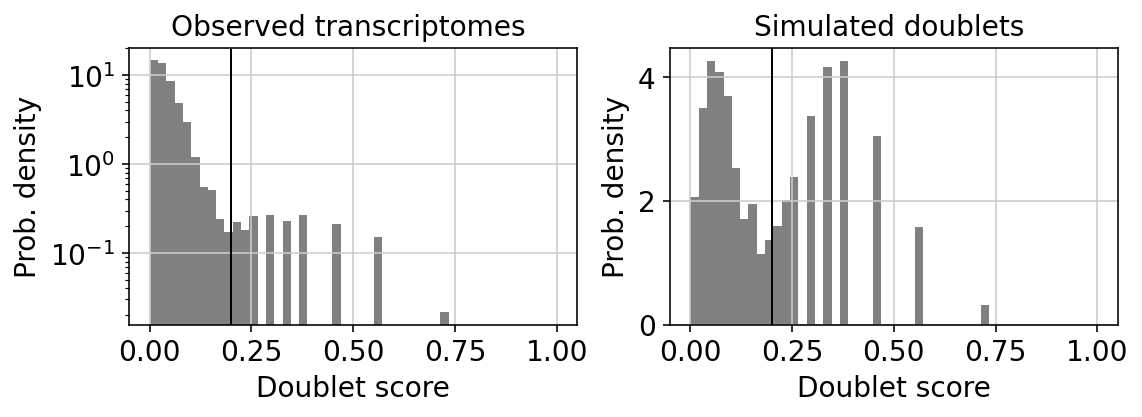

In [25]:
%matplotlib inline
for i in range(numberobj):
    print(names[i])
    sc.external.pl.scrublet_score_distribution(locals()[object_names[i]], scale_hist_obs='log', scale_hist_sim='linear', figsize=(8, 3),show=True,return_fig=True)

### Add QC and get rid of mitochondrial genes

In [14]:
adata_siletti_custom


AnnData object with n_obs × n_vars = 7646 × 59459
    obs: 'n_counts', 'species', 'sample_group', 'atlas', 'reference', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types'
    uns: 'scrublet'

<b> check this: sc.pp.calculate_qc_metrics() </b> <br>
expr_type: kind of values in X (str)<br>
var_type: kind of variables (str)<br>
qc_vars: keys for variables you want to control (collection of str)<br>
percent_top: proportions of top genes to cover, for cummulative proportion of counts (collection of int)<br>
layer: alternative layers for expression data (str)<br>
use_raw: use adata.raw.X for expression values (bool)<br>
inplace: place metrics in adata (bool)<br>
log1p: compute log1p transformed annotations, for very small values (bool)<br>
<br>
<b> return features obs </b> <br>
n_genes_by_counts: The number of genes with at least 1 count in a cell. <br>
total_counts: Total number of counts for a cell. <br>
total_counts_mt:Total number of mt gene counts for a cell. <br>
pct_counts_mt: Proportion (%) of total counts for a cell which are mitochondrial. <br> 
n_genes: Number of genes with a positive count. <br>
total_counts_ribo: Total number of ribosomal counts for a cell. <br>
pct_counts_ribo: Proportion of total counts for a cell which are ribosomal.

In [26]:
import numpy as np

for i in range(numberobj):
    #add mt variable annotation indicating if a gene is ribosomal or not (bool)
    if locals()[object_names[i]].obs['species'][0] == 'Homo sapien':
        locals()[object_names[i]].var['mt'] = locals()[object_names[i]].var_names.str.startswith('MT-')
    elif locals()[object_names[i]].obs['species'][0] == 'Mus musculus':
        locals()[object_names[i]].var['mt'] = locals()[object_names[i]].var_names.str.startswith('mt-') 
        
    if locals()[object_names[i]].obs['species'][0] == 'Homo sapien':
        locals()[object_names[i]].var['ribo'] = locals()[object_names[i]].var_names.str.startswith('RP')
    elif locals()[object_names[i]].obs['species'][0] == 'Mus musculus':
        locals()[object_names[i]].var['ribo'] = locals()[object_names[i]].var_names.str.startswith('Rp')
    
    sc.pp.calculate_qc_metrics(locals()[object_names[i]], expr_type='counts', var_type='genes', qc_vars=('mt','ribo'), percent_top= (), layer= None, use_raw= False, inplace=True, log1p=True)
     
    locals()[object_names[i]].var_names_make_unique()
    sc.pp.filter_cells(locals()[object_names[i]], min_genes=1) #remove all cells with 0 genes
                 
    # The following is to solve a save issue. Probably because of the NA valies in ther 'predicted_doublet' slot
    locals()[object_names[i]].obs['predicted_doublet'] =  locals()[object_names[i]].obs['predicted_doublet'].astype('str')

    

Checking median number of mitochondrial genes, genes and UMIs per cell to have an idea of the quality of each run:

In [27]:
print("Median numbers before filtering mt genes")
for i in range(numberobj):
    print(
         object_names[i],'\n',"\tmito%:",np.median(locals()[object_names[i]].obs['pct_counts_mt']),'\n',"\tmedian genes/nuclei:",np.median(locals()[object_names[i]].obs['n_genes']),'\n', 
            "\tmedian reads/nuclei:",np.median(locals()[object_names[i]].obs['total_counts']),'\n',
           "\tmean genes/nuclei:",int(np.mean(locals()[object_names[i]].obs['n_genes'])),'\n',
         "\tmean reads/nuclei:",  int(np.mean(locals()[object_names[i]].obs['total_counts'])), '\n')
    

Median numbers before filtering mt genes
adata_siletti_custom 
 	mito%: 0.29313233 
 	median genes/nuclei: 2733.0 
 	median reads/nuclei: 6265.0 
 	mean genes/nuclei: 3549 
 	mean reads/nuclei: 11814 

adata_siletti_standard 
 	mito%: 0.2979146 
 	median genes/nuclei: 2670.0 
 	median reads/nuclei: 6162.0 
 	mean genes/nuclei: 3470 
 	mean reads/nuclei: 11615 

adata_altena_custom 
 	mito%: 0.08801157 
 	median genes/nuclei: 2926.0 
 	median reads/nuclei: 7747.0 
 	mean genes/nuclei: 2996 
 	mean reads/nuclei: 8676 

adata_altena_standard 
 	mito%: 0.089630835 
 	median genes/nuclei: 2856.0 
 	median reads/nuclei: 7599.0 
 	mean genes/nuclei: 2926 
 	mean reads/nuclei: 8519 



In [28]:
print(adata_siletti_custom)
print(adata_siletti_custom.obs['total_counts'])
print(adata_siletti_custom.obs['pct_counts_mt'])

AnnData object with n_obs × n_vars = 8227 × 59459
    obs: 'n_counts', 'species', 'sample_group', 'atlas', 'reference', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'scrublet'
AAACCCAAGTTTCGAC     3514.0
AAACCCACATCGTTCC     8733.0
AAACCCAGTTATTCTC     6543.0
AAACCCATCGAGAGCA     8552.0
AAACCCATCGGAGTGA    25959.0
                     ...   
TTTGGTTGTGAGTAAT      928.0
TTTGGTTTCGCCTATC    10695.0
TTTGGTTTCTAAGAAG    29869.0
TTTGTTGCACCCAAGC    10919.0
TTTGTTGCAGGCATTT    20011.0
Name: total_counts, Length: 8227, dtype: float32
AAACCCAAGTTTCGAC    0.056915
AAACCCACATCGTTCC    0.194664
AAACCCAGTTAT

Filtering out mito genes to determine number of non mitochondrial genes:

In [29]:
for i in range(numberobj):
    #list all non mitochondrial genes for subsetting the columns
    if locals()[object_names[i]].obs['species'][0] == 'Homo sapien':
         non_mito_genes_list = [name for name in locals()[object_names[i]].var_names if not name.startswith('MT-')]
    elif locals()[object_names[i]].obs['species'][0] == 'Mus musculus':
        non_mito_genes_list = [name for name in locals()[object_names[i]].var_names if not name.startswith('mt-')]
    
    
    locals()[object_names[i]] = locals()[object_names[i]][:, non_mito_genes_list].copy()
    
    locals()[object_names[i]].obs['total_counts_mito'] =  locals()[object_names[i]].obs['total_counts']
    
    
    #recalculate the number of genes, because some cells only had mt gene counts
    sc.pp.filter_cells(locals()[object_names[i]], min_genes=1)

### Recalculate metrics 
Note that the qc_vars=None because we want to keep the mt%."


In [30]:
for i in range(numberobj):
    sc.pp.calculate_qc_metrics(locals()[object_names[i]], expr_type='counts', var_type='genes', qc_vars=(), percent_top= (), layer= None, use_raw= False, inplace=True, log1p=True)
adata_siletti_custom
print(adata_siletti_custom.obs['total_counts'])
print(adata_siletti_custom.obs['pct_counts_mt'])

AAACCCAAGTTTCGAC     3512.0
AAACCCACATCGTTCC     8716.0
AAACCCAGTTATTCTC     6536.0
AAACCCATCGAGAGCA     8550.0
AAACCCATCGGAGTGA    25767.0
                     ...   
TTTGGTTGTGAGTAAT      915.0
TTTGGTTTCGCCTATC    10616.0
TTTGGTTTCTAAGAAG    29698.0
TTTGTTGCACCCAAGC    10808.0
TTTGTTGCAGGCATTT    19931.0
Name: total_counts, Length: 8227, dtype: float32
AAACCCAAGTTTCGAC    0.056915
AAACCCACATCGTTCC    0.194664
AAACCCAGTTATTCTC    0.106985
AAACCCATCGAGAGCA    0.023386
AAACCCATCGGAGTGA    0.739628
                      ...   
TTTGGTTGTGAGTAAT    1.400862
TTTGGTTTCGCCTATC    0.738663
TTTGGTTTCTAAGAAG    0.572500
TTTGTTGCACCCAAGC    1.016577
TTTGTTGCAGGCATTT    0.399780
Name: pct_counts_mt, Length: 8227, dtype: float32


Check for the basic statistics

In [31]:
sc.set_figure_params(figsize=[8,8])

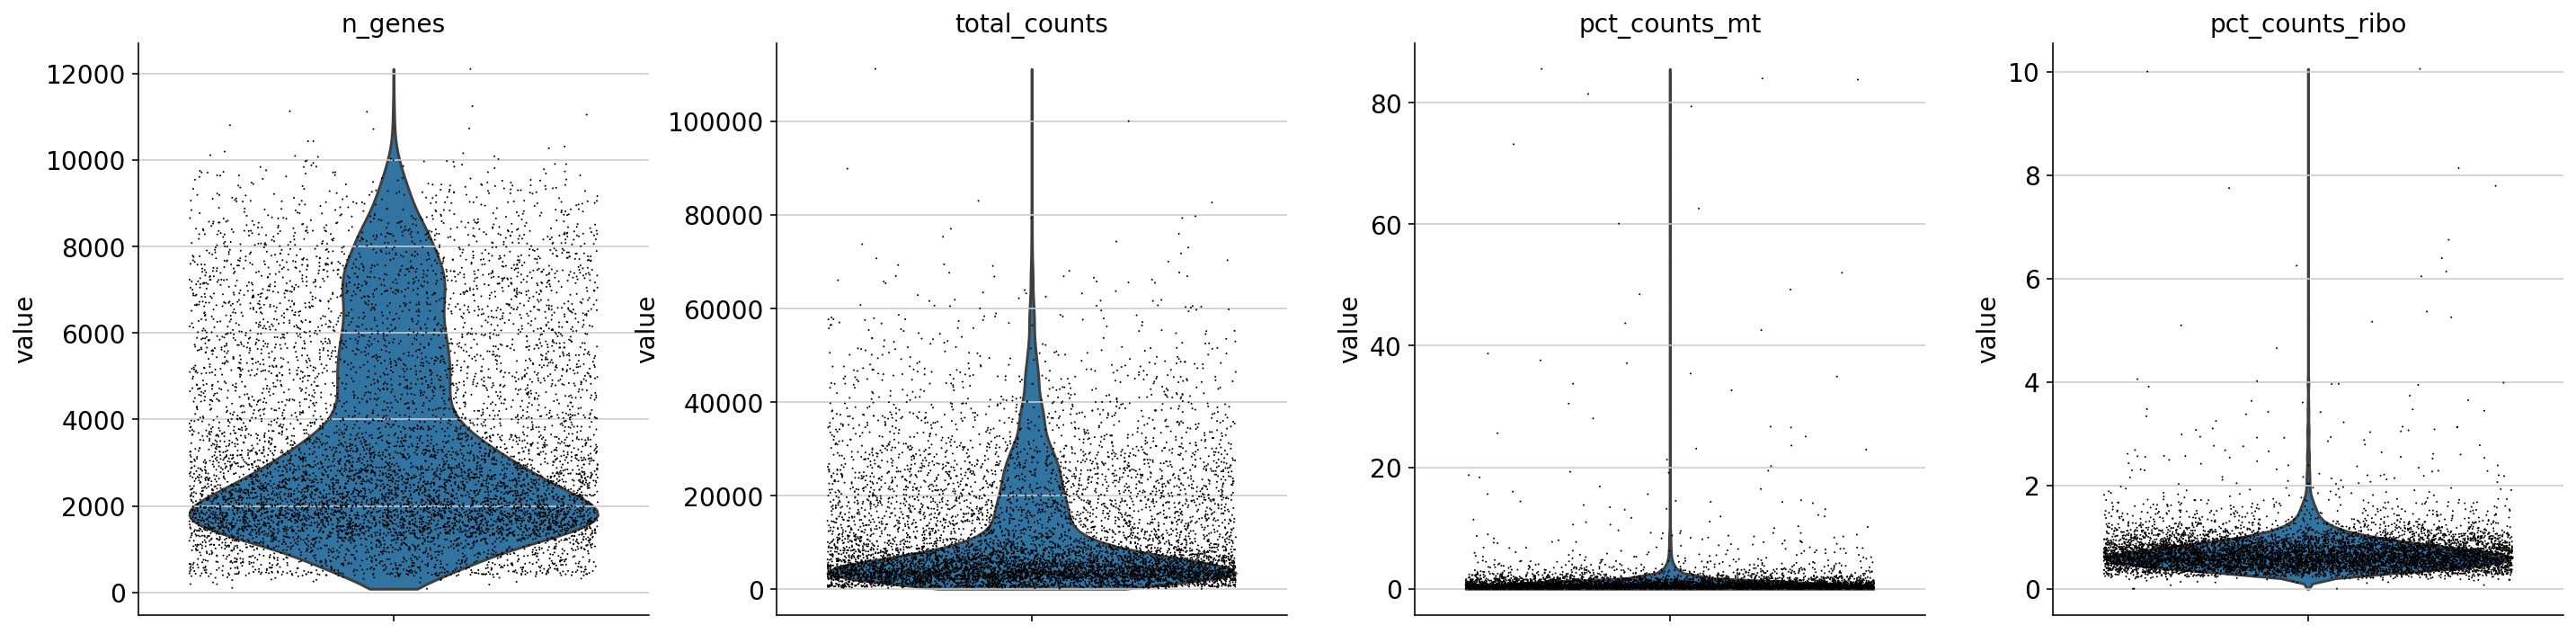

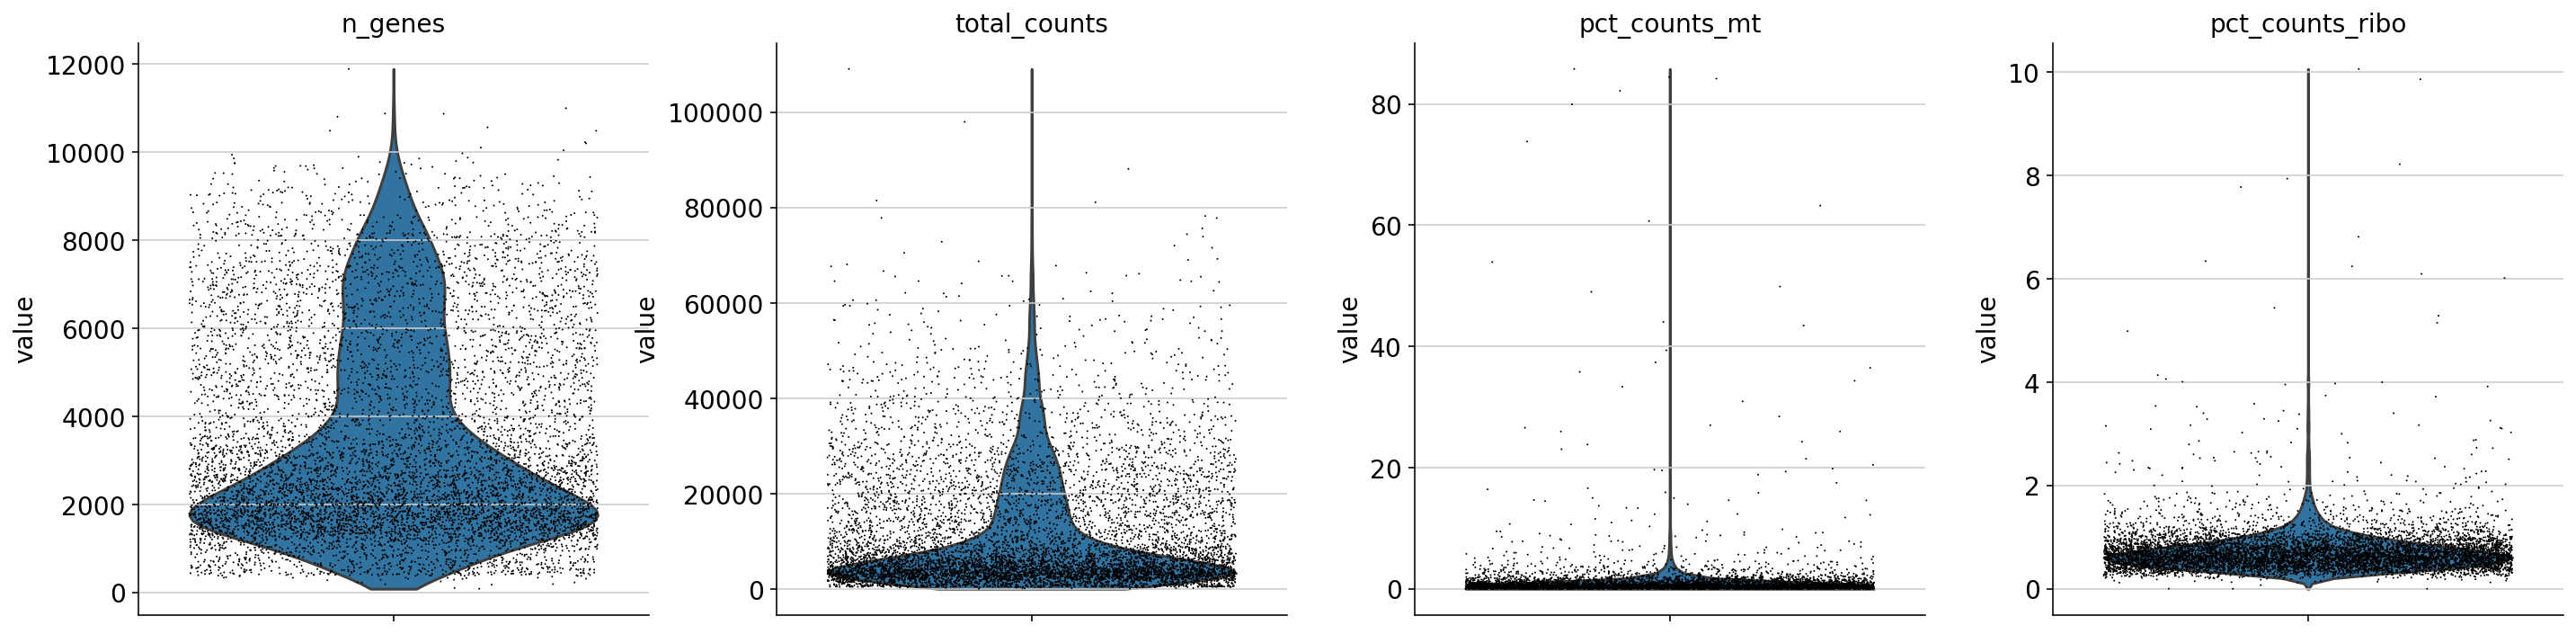

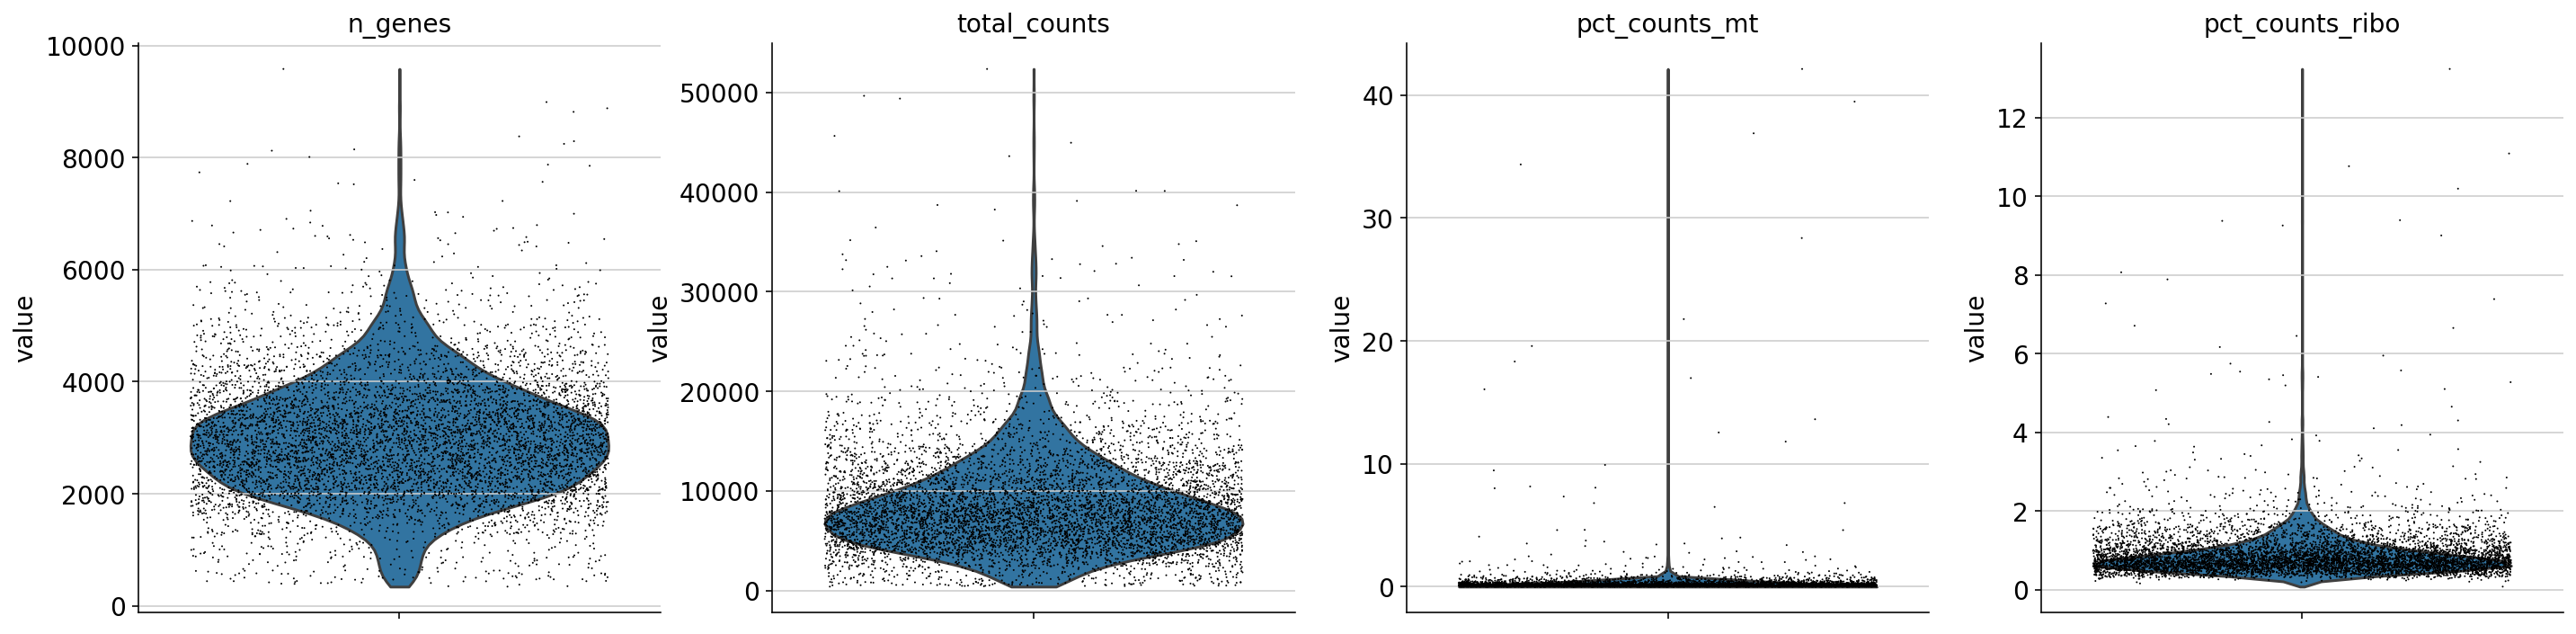

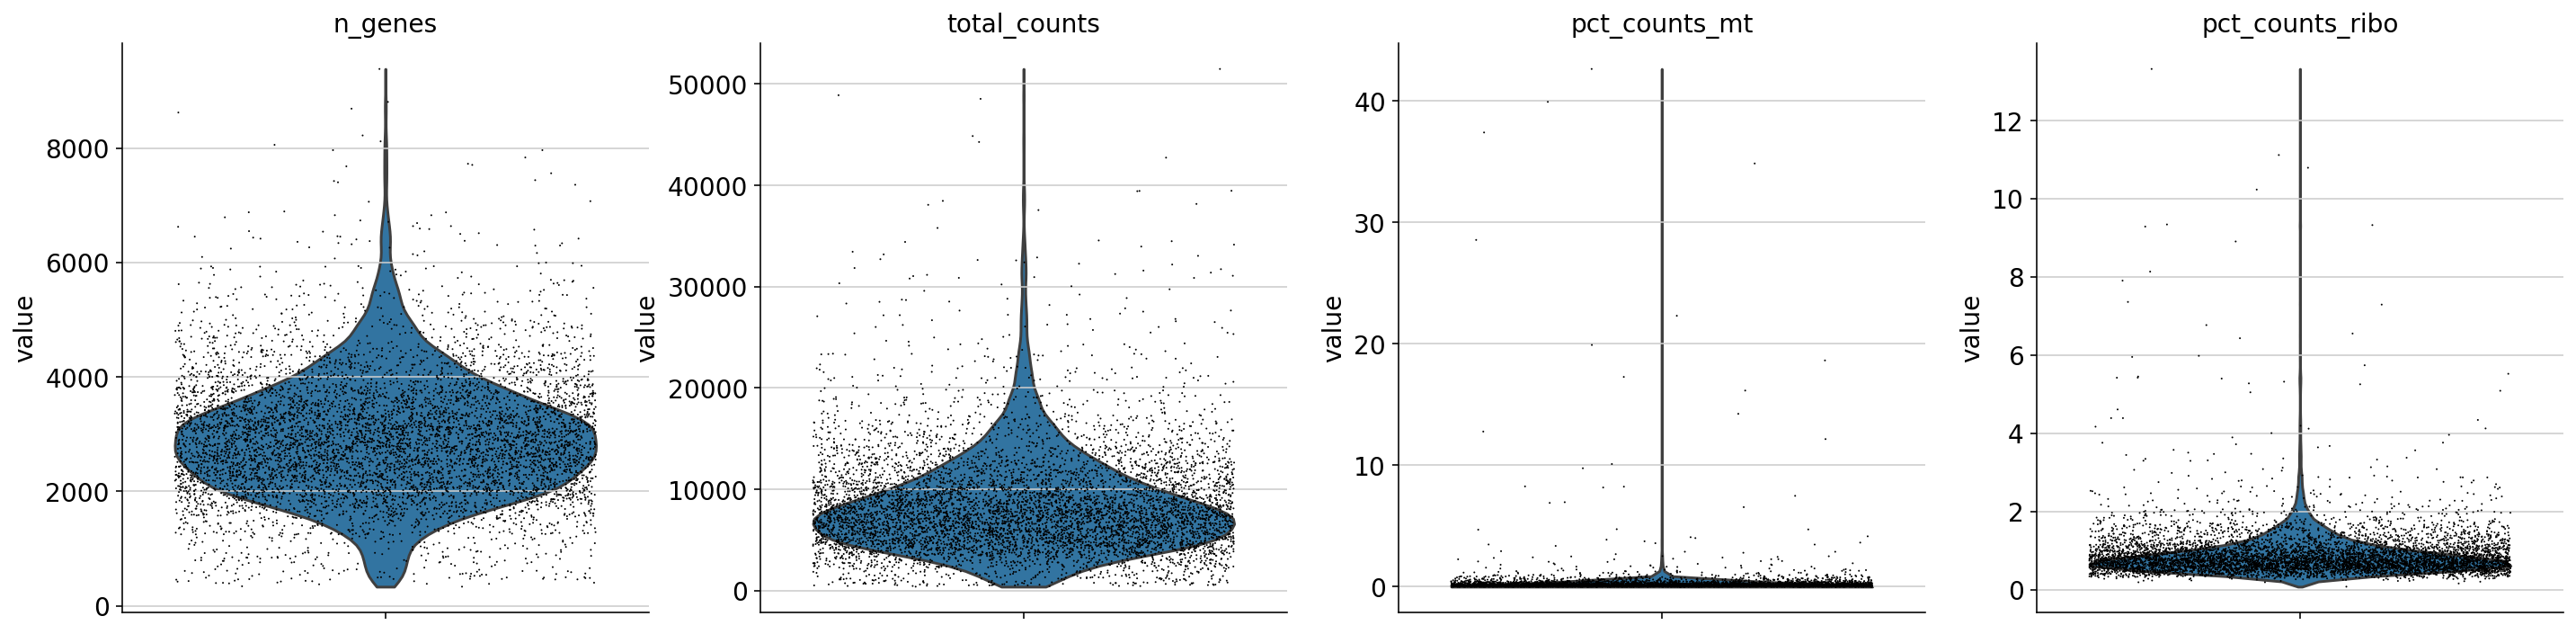

In [32]:
%matplotlib inline
for i in range(numberobj):
    sc.pl.violin(locals()[object_names[i]], ['n_genes', 'total_counts', 'pct_counts_mt','pct_counts_ribo'],
             jitter=0.4, multi_panel=True,size =1)#,save= object_names[i]+"_prefilter_all.pdf")
    plt.show()

In [33]:
print("Median numbers without mitochondrial reads\n")


for i in range(numberobj):
    median_counts = np.median(locals()[object_names[i]].obs['total_counts_mito'])
    mean_counts= int(np.mean(locals()[object_names[i]].obs['total_counts_mito']))

    median_counts_mito = np.median(locals()[object_names[i]].obs['total_counts']) 
    mean_counts_mito =int(np.mean(locals()[object_names[i]].obs['total_counts']))

    median_difference = median_counts - median_counts_mito 
    mean_difference = mean_counts -  mean_counts_mito
    
    pct_median_diff = median_difference / median_counts
    pct_mean_diff = mean_difference/mean_counts
    
    print(object_names[i],'\n',"\tmedian genes/nuclei:",np.median(locals()[object_names[i]].obs['n_genes']), '\n',
            "\tmedian reads/nuclei:",median_counts, '(',median_difference,'\t', pct_median_diff,'%',')','\n',
           "\tmean genes/nuclei:",int(np.mean(locals()[object_names[i]].obs['n_genes'])),'\n',
         "\tmean reads/nuclei:", mean_counts, '(',mean_difference,'\t', pct_mean_diff,'%',')','\n')

Median numbers without mitochondrial reads

adata_siletti_custom 
 	median genes/nuclei: 2726.0 
 	median reads/nuclei: 6265.0 ( 10.0 	 0.0015961692 % ) 
 	mean genes/nuclei: 3541 
 	mean reads/nuclei: 11814 ( 83 	 0.007025562891484679 % ) 

adata_siletti_standard 
 	median genes/nuclei: 2666.0 
 	median reads/nuclei: 6162.0 ( 18.0 	 0.0029211296 % ) 
 	mean genes/nuclei: 3463 
 	mean reads/nuclei: 11615 ( 83 	 0.007145931984502798 % ) 

adata_altena_custom 
 	median genes/nuclei: 2920.0 
 	median reads/nuclei: 7747.0 ( 12.0 	 0.0015489866 % ) 
 	mean genes/nuclei: 2990 
 	mean reads/nuclei: 8676 ( 13 	 0.0014983863531581375 % ) 

adata_altena_standard 
 	median genes/nuclei: 2851.0 
 	median reads/nuclei: 7599.0 ( 9.0 	 0.0011843664 % ) 
 	mean genes/nuclei: 2920 
 	mean reads/nuclei: 8519 ( 12 	 0.0014086160347458621 % ) 



### Save preprocessed files

In [49]:
for i in range(numberobj):
    locals()[object_names[i]].write(os.path.join('data/'+object_names[i][6:]+'_preprocessed.h5ad'))

In [52]:
!ls data/

altena_custom_preprocessed.h5ad
altena_standard_preprocessed.h5ad
siletti_custom_f1_processed_1.h5ad
siletti_custom_f1_reg_processed_1.h5ad
siletti_custom_filtered_1.h5ad
siletti_custom_preprocessed.h5ad
siletti_standard_f1_processed_1.h5ad
siletti_standard_f1_reg_processed_1.h5ad
siletti_standard_filtered_1.h5ad
siletti_standard_preprocessed.h5ad
